# Some attempt at Particle Tracking

In [273]:
# Importing things

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq

from lab_functions import *

In [274]:
# where is the data?
loc = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/2024-03-11/'
filename = 'Results.csv'

# read in as dataframe
df = pd.read_csv(loc + filename)

# select x and y positions of bead for all 83 frames
# get rid of anomalous last point
x = np.array(df['x'])[:-1]
y = np.array(df['y'])[:-1]

In [275]:
# Conversion Factor
pixels_microns = 15.36
pm_err = 0.5

x_mic = x*(1/pixels_microns)
y_mic = y*(1/pixels_microns)

x_mic_err = np.abs(x*(1/(pixels_microns+pm_err)) - x*(1/pixels_microns))
y_mic_err = np.abs(y*(1/(pixels_microns+pm_err)) - y*(1/pixels_microns))

Text(0.5, 1.0, 'Particle Tracks over 3 Seconds')

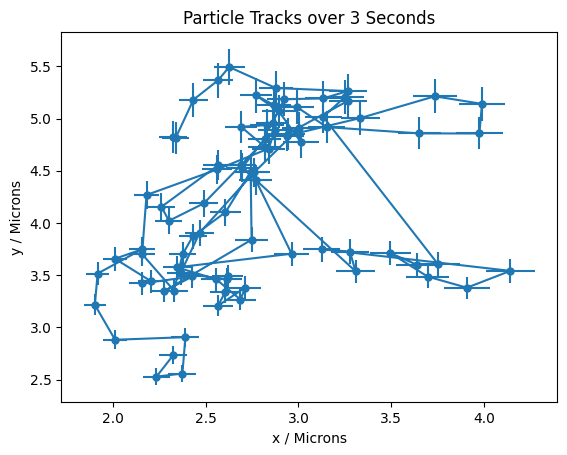

In [276]:
# Plot x and y trajectory

plt.errorbar(x_mic,y_mic, yerr = y_mic_err, xerr = x_mic_err, ms = 5, fmt = 'o', linestyle = '-')
plt.xlabel('x / Microns')
plt.ylabel('y / Microns')
plt.title('Particle Tracks over 3 Seconds')

Text(0, 0.5, 'Position / Microns')

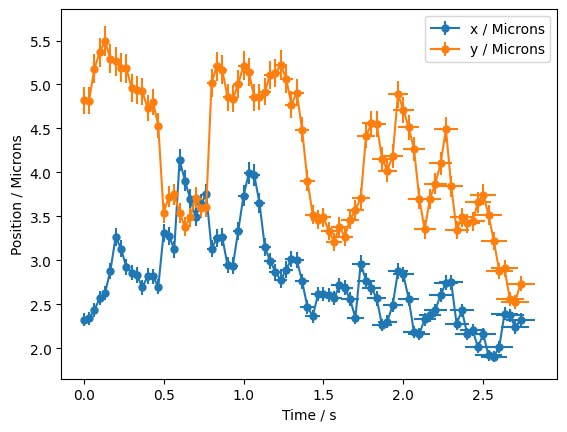

In [277]:
# Frames per second on camera
fps = 30
fps_err = 1

# Set time axis in seconds
time = np.arange(x.size) / 30
time_err = np.arange(x.size) * np.abs(1/31 - 1/30) # fps error is 1

# plot x and y over time
plt.errorbar(time,x_mic, xerr = time_err, yerr = x_mic_err, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic, xerr = time_err, yerr = y_mic_err, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position / Microns')

Text(0.5, 1.0, 'Particle Position with Time')

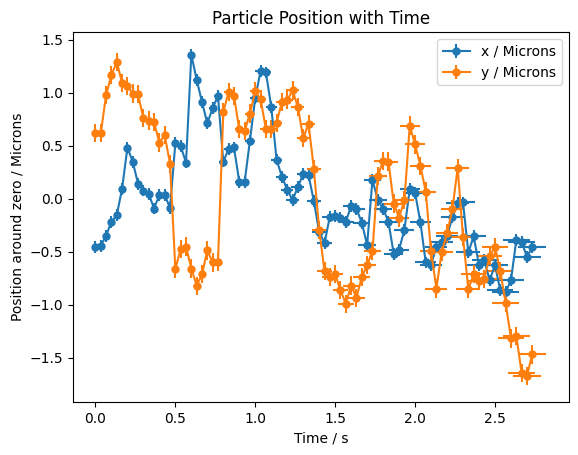

In [278]:
# Find mean of particle tracks to centre data on zero
x_mean = np.mean(x_mic)
y_mean = np.mean(y_mic)

# Error on mean = standard error
x_stderr = np.std(x_mic) / np.sqrt(len(x_mic))
y_stderr = np.std(y_mic) / np.sqrt(len(y_mic))

# Subtract mean from data
x_mic0 = x_mic - x_mean
y_mic0 = y_mic - y_mean

# Errors
x_mic0_err = np.abs( (x_mic - (x_mean+x_stderr)) - (x_mic - x_mean) )
y_mic0_err = np.abs( (y_mic - (y_mean+y_stderr)) - (y_mic - y_mean) )

# plot x and y over time
plt.errorbar(time,x_mic0, xerr = time_err, yerr = x_mic0_err, ms = 5, fmt = 'o', linestyle = '-', label = 'x / Microns')
plt.errorbar(time,y_mic0, xerr = time_err, yerr = y_mic0_err, ms = 5, fmt = 'o', linestyle = '-', label = 'y / Microns')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position around zero / Microns')
plt.title('Particle Position with Time')

Text(0, 0.5, 'Fourier Transform Squared / Arb Units')

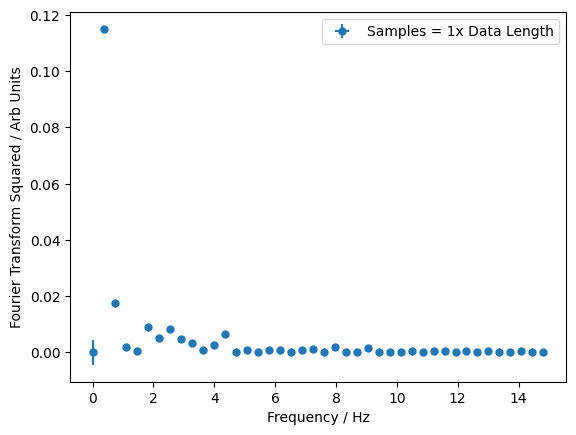

In [279]:
def fourier_calc(data, sample_number):

    # Compute transform and normalise by length / 2
    fast_four = rfft(data, n = sample_number) / (len(data) / 2)

    # Compute amplitude squared and divide by measurement time
    ps = np.abs(fast_four)**2 / time[-1]

    # Calculate frequency components (is the sample spacing right?)
    freq = rfftfreq(sample_number, d=1.0/fps)

    return ps, freq

ps, freq = fourier_calc(x_mic0, x_mic0.size)

# Errors
psplus, freqplus = fourier_calc(x_mic0+x_mic0_err, x_mic0.size)
ps_err = np.abs(psplus - ps) # mostly tiny
freq_err = np.abs(freqplus - freq) # all zero

# Plot using above function
plt.errorbar(freq, ps, xerr = freq_err, yerr = ps_err, ms = 5, fmt = 'o', linestyle = '',label = 'Samples = {}x Data Length'.format(1))
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Fourier Transform Squared / Arb Units')

C:\Users\abiga\AppData\Local\Temp\ipykernel_4524\3499516701.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-8,0)


(1e-08, 3.9873373128072704)

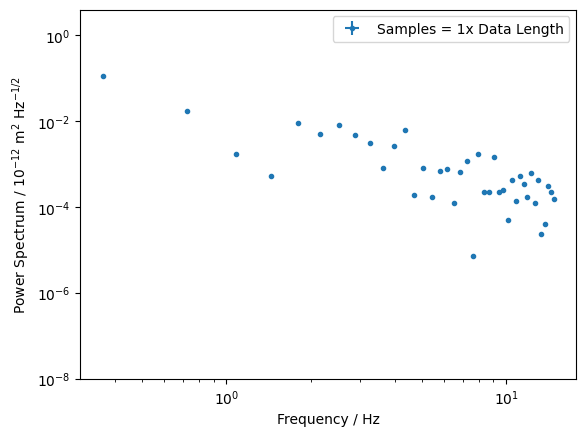

In [280]:
# Error on power spectrum - replace zeros

for i in range(len(ps_err)):
    if ps_err[i] == 0.0:
        ps_err[i] = 1e-30  # much smaller than other errors - basically zero

# Use a log scale
plt.errorbar(freq, ps, xerr = freq_err, yerr = ps_err, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o', ms = 3)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
plt.ylim(1e-8,0)

In [281]:
# Fit the above to Lorenzian Power Spectrum

def Lorentzian(x,A,f_0):
    return A / ((1 + x/f_0)**2)

ig = np.array([0.12,0.1])

# Fits to different errors in fit
yfit, parameters, perrors, chisq_reduced, p_value, dof = fit_labs(freq,ps,0.01,Lorentzian,ig)
yfitb, parametersb, perrorsb, chisq_reducedb, p_valueb, dofb = fit_labs(freq,ps,ps_err,Lorentzian,ig)

C:\Users\abiga\AppData\Local\Temp\ipykernel_4524\4036908610.py:26: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(1e-8,0)


The Amplitude of the Lorentzian is 0.040893596148966795 pm 0.008571259975294303 10^-12 m$^2$ Hz^-1/2$
The Cutoff Frequency is 2.1606797232957216 pm 0.8161740894118734 Hz
The reduced chi squared value for the fit is 2.391279560365353


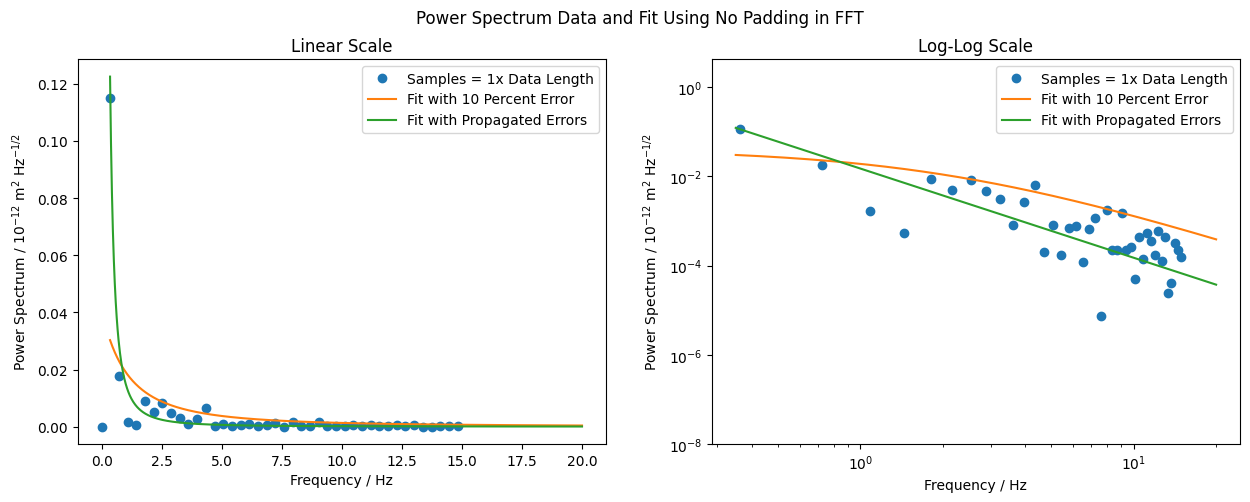

In [282]:
# Plot with Fit
# Use a log scale

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (15,5))

some_fs = np.linspace(0.35,20,1000)

fig.suptitle('Power Spectrum Data and Fit Using No Padding in FFT')

# Axis 1 - normal scale
ax1.plot(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o')
ax1.plot(some_fs, Lorentzian(some_fs,parameters[0],parameters[1]), label = 'Fit with 10 Percent Error', linestyle = '-')
ax1.plot(some_fs, Lorentzian(some_fs,parametersb[0],parametersb[1]), label = 'Fit with Propagated Errors', linestyle = '-')
ax1.legend()
ax1.set_xlabel('Frequency / Hz')
ax1.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
ax1.set_title('Linear Scale')

# Axis 2 - log scale
ax2.loglog(freq, ps, label = 'Samples = {}x Data Length'.format(1), linestyle = '', marker = 'o')
ax2.loglog(some_fs, Lorentzian(some_fs,parameters[0],parameters[1]), label = 'Fit with 10 Percent Error', linestyle = '-')
ax2.loglog(some_fs, Lorentzian(some_fs,parametersb[0],parametersb[1]), label = 'Fit with Propagated Errors', linestyle = '-')
ax2.legend()
ax2.set_xlabel('Frequency / Hz')
ax2.set_ylabel('Power Spectrum / 10$^{-12}$ m$^2$ Hz$^{-1/2}$')
ax2.set_ylim(1e-8,0)
ax2.set_title('Log-Log Scale')

print('The Amplitude of the Lorentzian is {} pm {} 10^-12 m$^2$ Hz^-1/2$'.format(parameters[0], perrors[0]))
print('The Cutoff Frequency is {} pm {} Hz'.format(parameters[1], perrors[1]))
print('The reduced chi squared value for the fit is {}'.format(chisq_reduced))

In [283]:
# Calculate the key parameters

# ROUGHLY 1.5 centi Poise 
# https://corecheminc.com/ethylene-glycol-water-mixture-properties/
eta = 1.5e-3 # Pa s
eta_err = 0.1e-3

# Radius of Beads
radius = 2.56e-6 / 2 # in microns
radius_err = 0.01e-6 / 2

# Boltzmanns const
k_b = 1.38e-23
# Temperature
T = 273+20
T_err = 5

# Caclulate stokes drag constant
beta = 6*np.pi*eta*radius

# Beta errors 
eta_cont = np.abs(6*np.pi*(eta+eta_err)*radius - 6*np.pi*eta*radius)
rad_cont = np.abs(6*np.pi*eta*(radius+radius_err) - 6*np.pi*eta*radius)
beta_err = np.sqrt(eta_cont**2 + rad_cont**2)

# Use cutoff freq to find stiffness constant, kappa
f0 = parameters[1]
f0_err = perrors[1]
stiffness = 2*np.pi*beta*f0

# Kappa Errors

beta_cont = np.abs(2*np.pi*(beta+beta_err)*f0 - 2*np.pi*beta*f0)
f0_cont = np.abs(2*np.pi*beta*(f0+f0_err) - 2*np.pi*beta*f0)
stiffness_err = np.sqrt(beta_cont**2 + f0_cont**2)

print('The Stiffness Constant is k = {} pm {} micro N m^-1'.format(stiffness*1e6, stiffness_err*1e6))

The Stiffness Constant is k = 0.4913292466110871 pm 0.1884725393642323 micro N m^-1


In [284]:
# Trapping Force - kx

''' Use standard deviation as delta x?'''
delta_x = np.std(x_mic0) * 1e-6 # CONVERT TO METRES
force = stiffness*delta_x
force_err = stiffness_err*delta_x
print('The force is {} pm {} pN'.format(force*1e12,force_err*1e12))

The force is 0.24851229487626178 pm 0.09532862861639597 pN


In [285]:
# F = QnP / c
# so Q = Fc / nP

power = 1e-3 # in watts
power_err = 1e-3
n = 1.38805 # see https://pubs.acs.org/doi/10.1021/je900630n 
c = 3e8

Q = force*c / n*power

# Error on Q - not including n or c
power_cont = np.abs( (force*c / n*(power+power_err)) - (force*c / n*power) )
force_cont = np.abs( ((force+force_err)*c / n*power) - (force*c / n*power) )
Q_err = np.sqrt(force_cont**2 + power_cont**2)

print('The Trapping Efficiency Q is {} pm {}'.format(Q,Q_err))
print('With error included, this is essentially zero')

The Trapping Efficiency Q is 5.371109719597892e-08 pm 5.752723891969087e-08
With error included, this is essentially zero


# Second Idea - Look at Equiparition Theorem

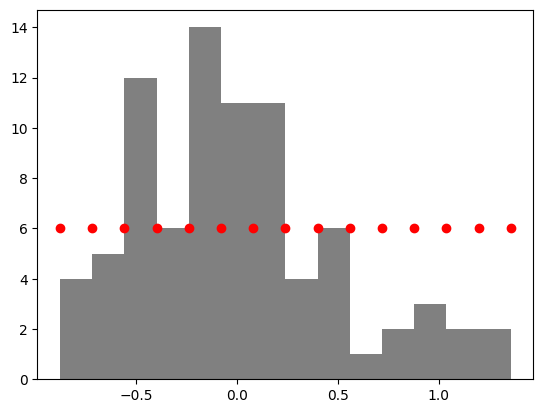

In [286]:
# Create and plot quick histogram
figHist, ax = plt.subplots()

# Sort Data
sorted_x = np.sort(x_mic0)
# Compute Histogram
counts, bins = np.histogram(sorted_x, bins = 14)
# Plot Histogram
ax.stairs(counts, bins, fill=True, color = 'grey')
ax.scatter(bins,np.ones(len(bins))*6, color = 'red')

In [287]:
# Fitting

def exp(x,C,alpha):
    return alpha*np.exp(-C*x**2)

igexp = np.array([1,1])

# Fits to no padding and padding in fft
''' WARNING: Arb error here. Needs work '''
yfitexp, parametersexp, perrorsexp, chisq_reducedexp, p_valueexp, dofexp = fit_labs(bins[:-1],counts,1,exp,igexp)

The constant C related to stiffness is 1.6633370047523255 pm 0.008571259975294303
The constant alpha related to amplitude is 10.00716133880672 pm 0.8161740894118734


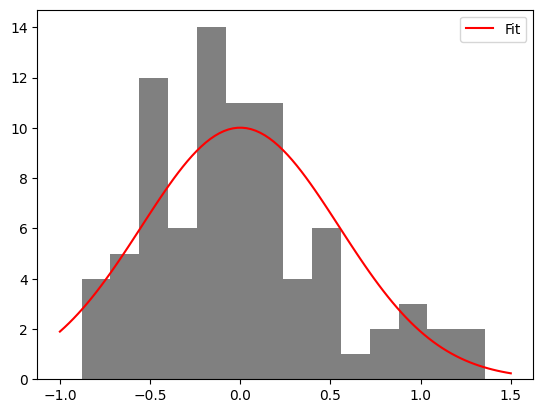

In [288]:
# Plot Histogram
some_bins = np.linspace(-1,1.5,100)

plt.stairs(counts, bins, fill=True, color = 'grey')
plt.plot(some_bins,exp(some_bins,parametersexp[0],parametersexp[1]), label = 'Fit', color = 'red')
plt.legend()
print('The constant C related to stiffness is {} pm {}'.format(parametersexp[0],perrors[0]))
print('The constant alpha related to amplitude is {} pm {}'.format(parametersexp[1],perrors[1]))